# 시스템 품질 변화로 인한 사용자 불편 예지 AI 경진대회
* 주제: 비식별화 된 시스템 기록(로그 및 수치 데이터)을 분석하여 시스템 품질 변화로 사용자에게 불편을 야기하는 요인을 진단
* 배경: 다양한 장비/서비스에서 일어나는 시스템 데이터를 통해 사용자의 불편을 예지하기 위해 ‘시스템 데이터’와 ‘사용자 불편 발생 데이터’를 분석하여 불편을 느낀 사용자와 불편 요인들을 찾아주세요.
* 목적
    * 데이터를 통해 사용자가 불편을 느끼는 원인 분석
    * 사용자 관점의 데이터 분석 능력이 뛰어난 인재 발굴

<br><br>
## 0. Library

In [57]:
import pandas as pd
import numpy as np
import datetime as dt
import re

import matplotlib.pyplot as plt
import seaborn as sns

<br><br>
## 1. Data
* 학습 데이터 (user_id : 10000 ~ 24999, 15000명)
    * train_err_data.csv : 시스템에 발생한 에러 로그
    * train_quality_data.csv : 시스템 퀄리티 로그
    * train_problem_data.csv : 사용자 불만 및 불만이 접수된 시간
<br><br>
* 테스트 데이터(user_id : 30000 ~ 44998, 14999명)
    * test_err_data.csv : 시스템에 발생한 에러 로그
    * test_quality_data.csv : 시스템 퀄리티 로그
    * sample_submission.csv : 사용자 불만 확률(0~1) (제출용)
<br><br>

In [60]:
# 학습 데이터
train_err = pd.read_csv('data/train_err_data.csv')
train_qual = pd.read_csv('data/train_quality_data.csv')
train_prob = pd.read_csv('data/train_problem_data.csv')

# 테스트 데이터
test_err = pd.read_csv('data/test_err_data.csv')
test_qual = pd.read_csv('data/test_quality_data.csv')
submission = pd.read_csv('data/sample_submission.csv')

C:\Users\Hyein999\anaconda3\envs\pydatavenv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Hyein999\anaconda3\envs\pydatavenv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [111]:
train_prob

,user_id,time
0,19224,20201102200000
1,23664,20201116140000
2,15166,20201114130000
3,12590,20201108210000
4,15932,20201103210000
...,...,...
5424,20167,20201125120000
5425,16270,20201110120000
5426,19114,20201106230000
5427,21505,20201104110000


In [27]:
## datetime으로 바꾸기
train_err['time'] = train_err['time'].apply(lambda x: dt.datetime(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:8]), int(str(x)[8:10])))
train_qual['time'] = train_qual['time'].apply(lambda x: dt.datetime(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:8]), int(str(x)[8:10])))
train_prob['time'] = train_prob['time'].apply(lambda x: dt.datetime(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:8]), int(str(x)[8:10])))

test_err['time'] = test_err['time'].apply(lambda x: dt.datetime(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:8]), int(str(x)[8:10])))
test_qual['time'] = test_qual['time'].apply(lambda x: dt.datetime(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:8]), int(str(x)[8:10])))

* **에러 로그(train_arr, test_arr)**
    * user_id
    * time >> **datetime으로 변경**
    * model_nm: 장비(0~8)
    * fwver: 펌웨어 버전(model 마다 다름)
    * errtype: 1~42(29는 없음)
    * errcode: 2806가지

In [73]:
train_err

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0
...,...,...,...,...,...,...
16554658,24999,20201130163051,model_3,05.15.2138,15,1
16554659,24999,20201130172625,model_3,05.15.2138,16,1
16554660,24999,20201130172625,model_3,05.15.2138,4,0
16554661,24999,20201130172631,model_3,05.15.2138,4,0


In [29]:
# 데이터 유형
train_err.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16554663 entries, 0 to 16554662
Data columns (total 6 columns):
 #   Column    Dtype         
---  ------    -----         
 0   user_id   int64         
 1   time      datetime64[ns]
 2   model_nm  object        
 3   fwver     object        
 4   errtype   int64         
 5   errcode   object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 757.8+ MB


In [30]:
# 결측치
print(train_err.isna().sum())
train_err[train_err['errcode'].isna()]

user_id     0
time        0
model_nm    0
fwver       0
errtype     0
errcode     1
dtype: int64


,user_id,time,model_nm,fwver,errtype,errcode
3825744,13639,2020-11-21 19:00:00,model_2,04.33.1261,5,NaN


In [31]:
# 모델명과 fwver과의 관계
train_err.groupby(['model_nm', 'fwver']).count()

user_id     time  errtype  errcode
model_nm fwver                                         
model_0  04.22.1442     2522     2522     2522     2522
         04.22.1656       39       39       39       39
         04.22.1666        5        5        5        5
         04.22.1684     5554     5554     5554     5554
         04.22.1750  2874213  2874213  2874213  2874213
         04.22.1778  1293946  1293946  1293946  1293946
model_1  04.16.2641      296      296      296      296
         04.16.3345      101      101      101      101
         04.16.3439      142      142      142      142
         04.16.3553  5237816  5237816  5237816  5237816
         04.16.3569      980      980      980      980
         04.16.3571   145156   145156   145156   145156
model_2  04.33.1095      909      909      909      909
         04.33.1125      408      408      408      408
         04.33.1149     3272     3272     3272     3272
         04.33.1171       58       58       58       58
         04.33.1185   963736   963736   963736   963736
         04.33.1261  2504871  2504871  2504871  2504870
model_3  05.15.2090       12       12       12       12
         05.15.2092       18       18       18       18
         05.15.2114        9        9        9        9
         05.15.2120      706      706      706      706
         05.15.2122       23       23       23       23
         05.15.2138  1906479  1906479  1906479  1906479
         05.15.3104      191      191      191      191
model_4  03.11.1141       29       29       29       29
         03.11.1149     2114     2114     2114     2114
         03.11.1167  1505659  1505659  1505659  1505659
model_5  04.82.1684    23554    23554    23554    23554
         04.82.1730       78       78       78       78
         04.82.1778     8601     8601     8601     8601
model_6  10             1534     1534     1534     1534
         8.5.3           212      212      212      212
model_7  05.66.3237    31832    31832    31832    31832
         05.66.3571     3524     3524     3524     3524
model_8  04.73.2237    33537    33537    33537    33537
         04.73.2571     2527     2527     2527     2527

In [32]:
# 모델과 에러타입
ex = train_err.groupby(['model_nm', 'errtype']).count()
ex.loc['model_1']
ex.loc['model_1']

,user_id,time,fwver,errcode
errtype,,,,
1,69,69,69,69
2,655,655,655,655
3,3,3,3,3
4,2720,2720,2720,2720
5,220544,220544,220544,220544
6,8985,8985,8985,8985
7,9807,9807,9807,9807
8,10,10,10,10
9,23,23,23,23


In [33]:
# 에러코드
train_err['errcode'].value_counts()

1                     8906967
0                     2599123
connection timeout    1835600
B-A8002                897863
80                     334018
                       ...   
5941                        1
40013                       1
3429                        1
5237                        1
4262                        1
Name: errcode, Length: 2805, dtype: int64

* **퀄리티 로그(train_qual, test_qual)**
    * user_id
    * fwver
    * quality_0~12: 데이터 타입 처리

In [74]:
train_qual

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
1,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
2,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
3,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
4,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828619,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,1,0,0,0,0,17,0,0
828620,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0
828621,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,3,0,0,0,0,17,0,0
828622,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0


In [35]:
train_qual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        828624 non-null  datetime64[ns]
 1   user_id     828624 non-null  int64         
 2   fwver       788544 non-null  object        
 3   quality_0   684192 non-null  float64       
 4   quality_1   828624 non-null  int64         
 5   quality_2   788511 non-null  float64       
 6   quality_3   828624 non-null  int64         
 7   quality_4   828624 non-null  int64         
 8   quality_5   828604 non-null  object        
 9   quality_6   828624 non-null  int64         
 10  quality_7   828624 non-null  object        
 11  quality_8   828624 non-null  object        
 12  quality_9   828624 non-null  object        
 13  quality_10  828624 non-null  object        
 14  quality_11  828624 non-null  int64         
 15  quality_12  828624 non-null  int64         
dtypes:

In [36]:
train_qual.isna().sum()

time               0
user_id            0
fwver          40080
quality_0     144432
quality_1          0
quality_2      40113
quality_3          0
quality_4          0
quality_5         20
quality_6          0
quality_7          0
quality_8          0
quality_9          0
quality_10         0
quality_11         0
quality_12         0
dtype: int64

In [109]:
ex = train_qual.groupby(['fwver', 'time']).count()
ex[ex['user_id']>24]
train_qual[(train_qual['fwver']=='03.11.1167') & (train_qual['time']==20201101004000)]

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
178512,20201101004000,13225,03.11.1167,NaN,0,0.0,0,0,0,0,0,0,0,2,0,0
178513,20201101004000,13225,03.11.1167,NaN,0,0.0,0,0,0,0,0,0,0,2,0,0
178514,20201101004000,13225,03.11.1167,NaN,0,0.0,0,0,2,0,0,0,0,2,0,0
178515,20201101004000,13225,03.11.1167,NaN,0,0.0,0,0,0,0,0,0,0,2,0,0
178516,20201101004000,13225,03.11.1167,NaN,0,0.0,0,0,0,0,0,0,0,2,0,0
178517,20201101004000,13225,03.11.1167,NaN,0,0.0,0,0,0,0,0,0,0,2,0,0
178518,20201101004000,13225,03.11.1167,NaN,0,0.0,0,0,0,0,0,0,0,2,0,0
178519,20201101004000,13225,03.11.1167,NaN,0,0.0,0,0,0,0,0,0,0,2,0,0
178520,20201101004000,13225,03.11.1167,NaN,-1,-1.0,0,0,-1,-1,0,0,0,2,-1,0
178521,20201101004000,13225,03.11.1167,NaN,-1,-1.0,0,0,-1,-1,0,0,0,2,-1,0


In [46]:
# train_qual.loc[:, 'quality_0':'quality_12'].value_counts()

quality_0  quality_1  quality_2  quality_3  quality_4  quality_5  quality_6  quality_7  quality_8  quality_9  quality_10  quality_11  quality_12
 0.0        0          0.0       0          0          0           0         0          0          0          3            0          0             48155
                                                                                                              2            0          0             34924
                                                                                                              4            0          0             24913
                                                                                                              5            0          0             17458
-1.0       -1         -1.0       0          0          -1         -1         0          0          0          3           -1          0             15665
                                                                                     

In [47]:
train_qual['quality_0'].value_counts()

 0.0       542790
-1.0       130828
 1.0         2097
 2.0         1252
 3.0          518
            ...  
 957.0          1
 3835.0         1
 959.0          1
 3837.0         1
 2039.0         1
Name: quality_0, Length: 753, dtype: int64

In [48]:
train_qual['quality_1'].value_counts()

 0      670270
-1      153649
 1        2567
 2        1140
 3         391
 4         202
 5         134
 6          71
 7          50
 8          35
 9          26
 10         24
 11         12
 12          7
 13          6
 14          5
 170         4
 18          4
 20          4
 21          4
 16          3
 17          3
 15          3
 169         2
 23          2
 171         1
 19          1
 35          1
 40          1
 88          1
 117         1
Name: quality_1, dtype: int64

In [49]:
train_qual['quality_5'].value_counts()

0         428096
-1        153354
1          56171
2          35978
3          21596
           ...  
1,575          1
1,377          1
1,898          1
2,965          1
11,030         1
Name: quality_5, Length: 4744, dtype: int64

In [72]:
train_qual.groupby(['user_id', 'time', 'fwver']).count()
# train_qual[(train_qual['user_id']==10000) & (train_qual['time']==20201129090000)]
# (train_qual['user_id']=='10000') 
# (train_qual['time']=='20201129090000')

quality_0  quality_1  quality_2  quality_3  \
user_id time           fwver                                                    
10000   20201129090000 05.15.2138         12         12         12         12   
        20201130210000 05.15.2138         12         12         12         12   
10002   20201104110000 05.15.2138         12         12         12         12   
        20201106010000 05.15.2138         12         12         12         12   
        20201111010000 05.15.2138         12         12         12         12   
...                                      ...        ...        ...        ...   
24993   20201130203000 05.15.2138         12         12         12         12   
24995   20201128202000 04.33.1261         12         12         12         12   
        20201129002000 04.33.1261         12         12         12         12   
24997   20201108230000 04.22.1750         12         12         12         12   
        20201124033000 04.22.1778         12         12         12         12   

                                   quality_4  quality_5  quality_6  quality_7  \
user_id time           fwver                                                    
10000   20201129090000 05.15.2138         12         12         12         12   
        20201130210000 05.15.2138         12         12         12         12   
10002   20201104110000 05.15.2138         12         12         12         12   
        20201106010000 05.15.2138         12         12         12         12   
        20201111010000 05.15.2138         12         12         12         12   
...                                      ...        ...        ...        ...   
24993   20201130203000 05.15.2138         12         12         12         12   
24995   20201128202000 04.33.1261         12         12         12         12   
        20201129002000 04.33.1261         12         12         12         12   
24997   20201108230000 04.22.1750         12         12         12         12   
        20201124033000 04.22.1778         12         12         12         12   

                                   quality_8  quality_9  quality_10  \
user_id time           fwver                                          
10000   20201129090000 05.15.2138         12         12          12   
        20201130210000 05.15.2138         12         12          12   
10002   20201104110000 05.15.2138         12         12          12   
        20201106010000 05.15.2138         12         12          12   
        20201111010000 05.15.2138         12         12          12   
...                                      ...        ...         ...   
24993   20201130203000 05.15.2138         12         12          12   
24995   20201128202000 04.33.1261         12         12          12   
        20201129002000 04.33.1261         12         12          12   
24997   20201108230000 04.22.1750         12         12          12   
        20201124033000 04.22.1778         12         12          12   

                                   quality_11  quality_12  
user_id time           fwver                               
10000   20201129090000 05.15.2138          12          12  
        20201130210000 05.15.2138          12          12  
10002   20201104110000 05.15.2138          12          12  
        20201106010000 05.15.2138          12          12  
        20201111010000 05.15.2138          12          12  
...                                       ...         ...  
24993   20201130203000 05.15.2138          12          12  
24995   20201128202000 04.33.1261          12          12  
        20201129002000 04.33.1261          12          12  
24997   20201108230000 04.22.1750          12          12  
        20201124033000 04.22.1778          12          12  

[65680 rows x 13 columns]

### train/test 차이

In [51]:
# Train-set에만 있는 칼럼은?
print(train_err.columns.difference( test_err.columns ))

# Train-set에만 있는 칼럼은?
print(train_qual.columns.difference( test_qual.columns ))

Index([], dtype='object')
Index([], dtype='object')


* user_id

In [52]:
# train_err / test_err의 user_id는?
display("train_err", train_err['user_id'].agg(['min','max']) )
print(f'Size : {len(train_err)}')

print('='* 80)

display("test_err",  test_err['user_id'].agg(['min','max']) )
print(f'Size : {len(test_err)}')

'train_err'

min    10000
max    24999
Name: user_id, dtype: int64

Size : 16554663


'test_err'

min    30000
max    44998
Name: user_id, dtype: int64

Size : 16532648


In [54]:
# train_quality / test_quality 의 user_id는?
display("train_qual", train_qual['user_id'].agg(['min','max']) )
print(f'Size : {len(train_qual)}')

print('='* 80)
display("test_qual",  test_qual['user_id'].agg(['min','max']) )
print(f'Size : {len(test_qual)}')

'train_qual'

min    10000
max    24997
Name: user_id, dtype: int64

Size : 828624


'test_qual'

min    30000
max    44997
Name: user_id, dtype: int64

Size : 747972


In [63]:
# Train/Test-set의 고유한 user_id 구함.
train_err_errtype_set = set(train_err['user_id'])
test_err_errtype_set  = set(test_err['user_id'])


# Train/Test-set 고유한 user_id 개수를 구함.
print(f"Train-set에 있는 고유한 user_id 개수 : { len(train_err_errtype_set) }")
print(f"Test-set에 있는 고유한 user_id 개수 : { len(test_err_errtype_set) }")

# Train/Test-set 모두에 포함되어있는 user_id 구함.
print('='* 80)
common_errtype = train_err_errtype_set.intersection(test_err_errtype_set)
print(f"Train/Test-set에 공통으로 포함되어 있는 user_id 개수 : {len(common_errtype)}")

# Train-set에만 있는 user_id 구함.
print('='* 80)
only_train_err_errtype = train_err_errtype_set.difference(test_err_errtype_set)
print(f"Train-set에만 있는 user_id 총 { len(only_train_err_errtype) }개 입니다.")
#print(f"Train-set에만 있는 user_id : { sorted(only_train_err_errtype ) }")

# Test-set에만 있는 user_id 구함.
print('='* 80)
only_test_err_errtype = test_err_errtype_set.difference(train_err_errtype_set)
print(f"Test-set에만 있는 user_id 총 { len(only_test_err_errtype) }개 입니다.")
#print(f"Test-set에만 있는 user_id : { sorted( only_test_err_errtype ) }")

Train-set에 있는 고유한 user_id 개수 : 15000
Test-set에 있는 고유한 user_id 개수 : 14998
Train/Test-set에 공통으로 포함되어 있는 user_id 개수 : 0
Train-set에만 있는 user_id 총 15000개 입니다.
Test-set에만 있는 user_id 총 14998개 입니다.


In [ ]:

train_err_errtype_set = set(tr_err['errtype'])
test_err_errtype_set  = set(ts_err['errtype'])


# Test-set에만 있는 user_id 구함.
print('='* 80)
only_ts_err_errtype = ts_err_errtype_set.difference(tr_err_errtype_set)
print(f"Test-set에만 있는 user_id 총 { len(only_ts_err_errtype) }개 입니다.")
#print(f"Test-set에만 있는 user_id : { sorted( only_test_err_errtype ) }")

* time

In [55]:
# train_err / test_err 의 time는?
display("train_err",  train_err['time'].agg(['min','max']) )
print(f'Size : {len(train_err)}')

print('='* 80)

display("test_err",  test_err['time'].agg(['min','max']) )
print(f'Size : {len(test_err)}')

'train_err'

min   2020-10-31 23:00:00
max   2020-12-02 18:00:00
Name: time, dtype: datetime64[ns]

Size : 16554663


'test_err'

min   2020-10-31 23:00:00
max   2020-12-14 12:00:00
Name: time, dtype: datetime64[ns]

Size : 16532648


In [56]:
# train_quality / test_quality 의 date는?
display("train_qual",  train_qual['time'].agg(['min','max']) )
print(f'Size : {len(train_qual)}')

print('='* 80)

display("test_qual",  test_qual['time'].agg(['min','max']) )
print(f'Size : {len(test_qual)}')

'train_qual'

min   2020-10-31 23:00:00
max   2020-11-30 23:00:00
Name: time, dtype: datetime64[ns]

Size : 828624


'test_qual'

min   2020-10-31 23:00:00
max   2020-11-30 23:00:00
Name: time, dtype: datetime64[ns]

Size : 747972


* model_nm

In [66]:
# Train/Test-set의 고유한 model_nm 구함.
train_err_errtype_set = set(train_err['model_nm'])
test_err_errtype_set  = set(test_err['model_nm'])


# Train/Test-set 고유한 model_nm 개수를 구함.
print(f"Train-set에 있는 고유한 model_nm 개수 : { len(train_err_errtype_set) }")
print(f"Test-set에 있는 고유한 model_nm 개수 : { len(test_err_errtype_set) }")

# Train/Test-set 모두에 포함되어있는 model_nm 구함.
print('='* 80)
common_errtype = train_err_errtype_set.intersection(test_err_errtype_set)
print(f"Train/Test-set에 공통으로 포함되어 있는 model_nm 개수 : {len(common_errtype)}")

# Train-set에만 있는 model_nm 구함.
print('='* 80)
only_train_err_errtype = train_err_errtype_set.difference(test_err_errtype_set)
print(f"Train-set에만 있는 model_nm 총 { len(only_train_err_errtype) }개 입니다.")
print(f"Train-set에만 있는 model_nm : { sorted(only_train_err_errtype ) }")

# Test-set에만 있는 model_nm 구함.
print('='* 80)
only_test_err_errtype = test_err_errtype_set.difference(train_err_errtype_set)
print(f"Test-set에만 있는 model_nm 총 { len(only_test_err_errtype) }개 입니다.")
print(f"Test-set에만 있는 model_nm : { sorted( only_test_err_errtype ) }")

Train-set에 있는 고유한 model_nm 개수 : 9
Test-set에 있는 고유한 model_nm 개수 : 9
Train/Test-set에 공통으로 포함되어 있는 model_nm 개수 : 9
Train-set에만 있는 model_nm 총 0개 입니다.
Train-set에만 있는 model_nm : []
Test-set에만 있는 model_nm 총 0개 입니다.
Test-set에만 있는 model_nm : []


* fwver

In [67]:
# Train/Test-set의 고유한 fwver 구함.
train_err_errtype_set = set(train_err['fwver'])
test_err_errtype_set  = set(test_err['fwver'])


# Train/Test-set 고유한 errtype의 개수를 구함.
print(f"Train-set에 있는 고유한 fwver 개수 : { len(train_err_errtype_set) }")
print(f"Test-set에 있는 고유한 fwver 개수 : { len(test_err_errtype_set) }")

# Train/Test-set 모두에 포함되어있는 errtype를 구함.
print('='* 80)
common_errtype = train_err_errtype_set.intersection(test_err_errtype_set)
print(f"Train/Test-set에 공통으로 포함되어 있는 fwver 개수 : {len(common_errtype)}")

# Train-set에만 있는 errtype를 구함.
print('='* 80)
only_train_err_errtype = train_err_errtype_set.difference(test_err_errtype_set)
print(f"Train-set에만 있는 fwver 총 { len(only_train_err_errtype) }개 입니다.")
print(f"Train-set에만 있는 fwver : { sorted(only_train_err_errtype ) }")

# Test-set에만 있는 errtype를 구함.
print('='* 80)
only_test_err_errtype = test_err_errtype_set.difference(train_err_errtype_set)
print(f"Test-set에만 있는 fwver 총 { len(only_test_err_errtype) }개 입니다.")
print(f"Test-set에만 있는 fwver : { sorted( only_test_err_errtype ) }")

Train-set에 있는 고유한 fwver 개수 : 37
Test-set에 있는 고유한 fwver 개수 : 40
Train/Test-set에 공통으로 포함되어 있는 fwver 개수 : 31
Train-set에만 있는 fwver 총 6개 입니다.
Train-set에만 있는 fwver : ['04.16.2641', '04.16.3345', '04.22.1442', '04.33.1095', '05.15.2090', '05.15.2122']
Test-set에만 있는 fwver 총 9개 입니다.
Test-set에만 있는 fwver : ['04.22.1170', '04.22.1448', '04.22.1478', '04.22.1608', '04.22.1772', '04.73.2569', '04.73.2577', '10.22.1770', '10.22.1780']


* errtype

In [69]:
# Train/Test-set의 고유한 errtype 구함.
train_err_errtype_set = set(train_err['errtype'])
test_err_errtype_set  = set(test_err['errtype'])


# Train/Test-set 고유한 errtype의 개수를 구함.
print(f"Train-set에 있는 고유한 errtype의 개수 : { len(train_err_errtype_set) }")
print(f"Test-set에 있는 고유한 errtype의 개수 : { len(test_err_errtype_set) }")

# Train/Test-set 모두에 포함되어있는 errtype를 구함.
print('='* 80)
common_errtype = train_err_errtype_set.intersection(test_err_errtype_set)
print(f"Train/Test-set에 공통으로 포함되어 있는 errtype 개수 : {len(common_errtype)}")

# Train-set에만 있는 errtype를 구함.
print('='* 80)
only_train_err_errtype = train_err_errtype_set.difference(test_err_errtype_set)
print(f"Train-set에만 있는 errtype는 총 { len(only_train_err_errtype) }개 입니다.")
print(f"Train-set에만 있는 errtype는 : { sorted(only_train_err_errtype ) }")

# Test-set에만 있는 errtype를 구함.
print('='* 80)
only_test_err_errtype = test_err_errtype_set.difference(train_err_errtype_set)
print(f"Test-set에만 있는 errtype는 총 { len(only_test_err_errtype) }개 입니다.")
print(f"Test-set에만 있는 errtype는 : { sorted( only_test_err_errtype ) }")

Train-set에 있는 고유한 errtype의 개수 : 41
Test-set에 있는 고유한 errtype의 개수 : 41
Train/Test-set에 공통으로 포함되어 있는 errtype 개수 : 41
Train-set에만 있는 errtype는 총 0개 입니다.
Train-set에만 있는 errtype는 : []
Test-set에만 있는 errtype는 총 0개 입니다.
Test-set에만 있는 errtype는 : []


* errcode

In [70]:
# Train/Test-set의 고유한 errcode 구함.
train_err_errtype_set = set(train_err['errcode'])
test_err_errtype_set  = set(test_err['errcode'])


# Train/Test-set 고유한 errcode 개수를 구함.
print(f"Train-set에 있는 고유한 errcode 개수 : { len(train_err_errtype_set) }")
print(f"Test-set에 있는 고유한 errcode 개수 : { len(test_err_errtype_set) }")

# Train/Test-set 모두에 포함되어있는 errcode 구함.
print('='* 80)
common_errtype = train_err_errtype_set.intersection(test_err_errtype_set)
print(f"Train/Test-set에 공통으로 포함되어 있는 errcode 개수 : {len(common_errtype)}")

# Train-set에만 있는 errcode 구함.
print('='* 80)
only_train_err_errtype = train_err_errtype_set.difference(test_err_errtype_set)
print(f"Train-set에만 있는 errcode 총 { len(only_train_err_errtype) }개 입니다.")
#print(f"Train-set에만 있는 errcode : { sorted(only_train_err_errtype ) }")

# Test-set에만 있는 errcode 구함.
print('='* 80)
only_test_err_errtype = test_err_errtype_set.difference(train_err_errtype_set)
print(f"Test-set에만 있는 errcode 총 { len(only_test_err_errtype) }개 입니다.")
#print(f"Test-set에만 있는 errcode : { sorted( only_test_err_errtype ) }")

Train-set에 있는 고유한 errcode 개수 : 2806
Test-set에 있는 고유한 errcode 개수 : 2956
Train/Test-set에 공통으로 포함되어 있는 errcode 개수 : 1408
Train-set에만 있는 errcode 총 1398개 입니다.
Test-set에만 있는 errcode 총 1548개 입니다.


<br><br>
## 2. EDA

### 1) train 과 test의 time 비교

20201031235959     5
20201101000000     9
20201101000001     8
20201101000002    16
20201101000003    22
                  ..
20201201211158     1
20201201212058     1
20201202024135     1
20201202031447     1
20201202185152     1
Name: time, Length: 2566163, dtype: int64

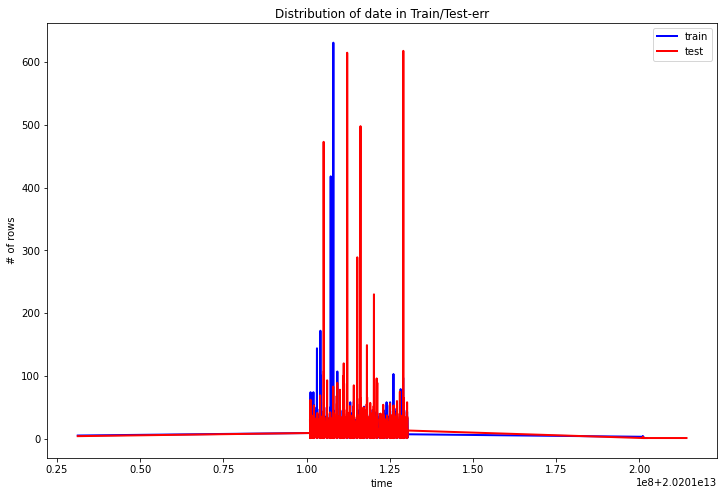

In [61]:
# train_err / test_err - time
# Figure을 정의
plt.figure(figsize = (12,8))

# Train/Test-set 각각에서 특정 date가 몇 번 등장했는지 시각화 시킴
display(train_err['time'].value_counts().sort_index())
train_err['time'].value_counts().sort_index().plot(color='b', lw=2, label='train')
test_err['time'].value_counts().sort_index().plot(color='r',  lw=2, label='test')

plt.legend()
plt.xlabel("time")
plt.ylabel("# of rows")
plt.title("Distribution of date in Train/Test-err");

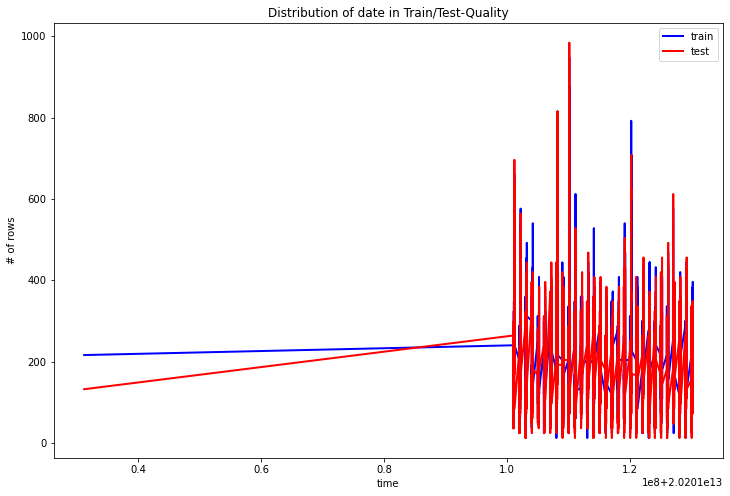

In [62]:
# train_quality / test_quality - time
# Figure을 정의
plt.figure(figsize = (12,8))

# Train/Test-set 각각에서 특정 date가 몇 번 등장했는지 시각화 시킴
train_qual['time'].value_counts().sort_index().plot(color='b', lw=2, label='train')
test_qual['time'].value_counts().sort_index().plot(color='r',  lw=2, label='test')

plt.legend()
plt.xlabel("time")
plt.ylabel("# of rows")
plt.title("Distribution of date in Train/Test-Quality")

### 2) 에러로그 컬럼 시각화

* user_id

Text(0.5, 1.0, 'Distribution ofuser_idin Train-Error')

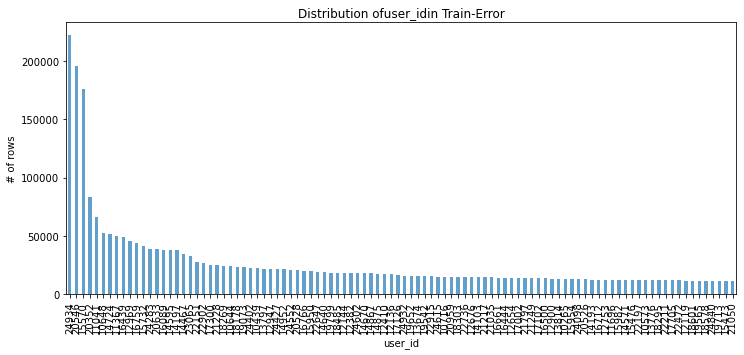

In [91]:
# fig = plt.figure(figsize=(18,9))
# plt.subplots_adjust(hspace=.5)

# plt.subplot2grid((3,3), (0,0), colspan = 3)
# train_err['user_id'].value_counts()[:100].plot(kind='bar', alpha=0.7)
# plt.title('type Values in the Training Set - train ()')

col = 'user_id'
plt.figure(figsize = (12,5))

train_err[col].value_counts()[:100].plot(kind='bar', alpha=0.7)

plt.xlabel(col)
plt.ylabel("# of rows")
plt.title("Distribution of"+col+"in Train-Error")

<AxesSubplot:xlabel='user_id'>

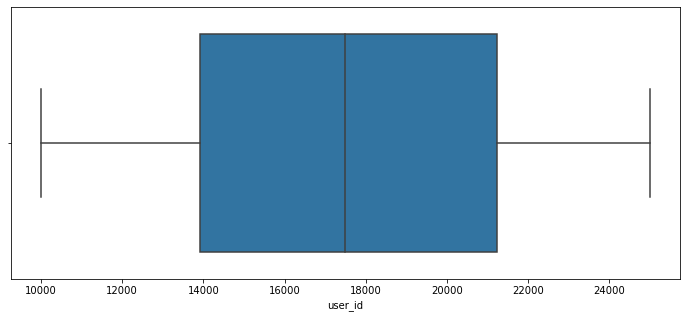

In [80]:
plt.figure(figsize=(12, 5))

# plt.xlim(train_err.user_id.min(), train_err.user_id.max()*1.1)
sns.boxplot(x=train_err.user_id)

* time

In [82]:
# plt.figure(figsize = (12,5))

# train_err['time'].value_counts()[:100].plot(kind='bar', alpha=0.7)

# plt.xlabel("time")
# plt.ylabel("# of rows")
# plt.title("Distribution of time in Train-Error")

* model_nm

Text(0.5, 1.0, 'Distribution ofmodel_nmin Train-Error')

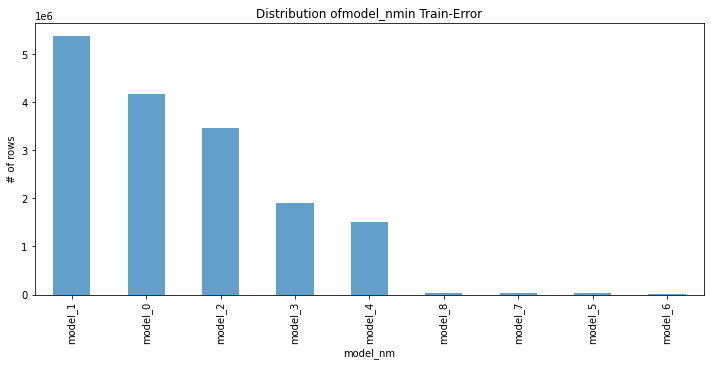

In [86]:
col = 'model_nm'
plt.figure(figsize = (12,5))

train_err[col].value_counts().plot(kind='bar', alpha=0.7)

plt.xlabel(col)
plt.ylabel("# of rows")
plt.title("Distribution of"+col+"in Train-Error")

* fwver

Text(0.5, 1.0, 'Distribution of fwver in Train-Error')

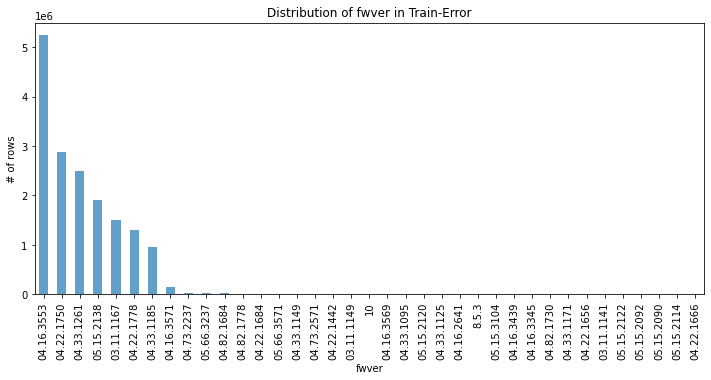

In [110]:
col = 'fwver'
plt.figure(figsize = (12,5))

train_err[col].value_counts().plot(kind='bar', alpha=0.7)

plt.xlabel(col)
plt.ylabel("# of rows")
plt.title("Distribution of "+col+" in Train-Error")

* errtype

Text(0.5, 1.0, 'Distribution oferrtypein Train-Error')

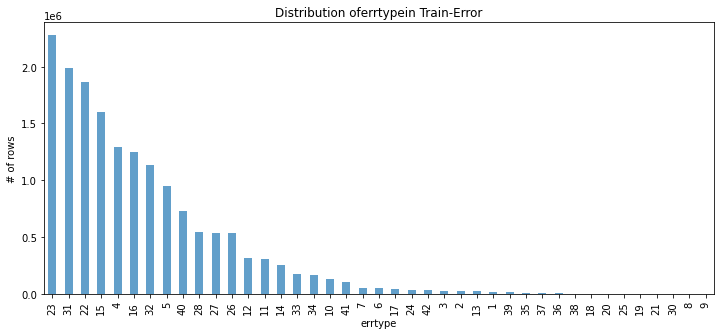

In [88]:
col = 'errtype'
plt.figure(figsize = (12,5))

train_err[col].value_counts().plot(kind='bar', alpha=0.7)

plt.xlabel(col)
plt.ylabel("# of rows")
plt.title("Distribution of"+col+"in Train-Error")

* errcode

In [ ]:
# col = 'errcode'
# plt.figure(figsize = (12,5))

# train_err[col].value_counts().plot(kind='bar', alpha=0.7)

# plt.xlabel(col)
# plt.ylabel("# of rows")
# plt.title("Distribution of"+col+"in Train-Error")